# Implementation of the CNN 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random 
from scipy.stats import loguniform, gamma, uniform
import time 
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import pickle
from scipy.integrate import simpson
from scipy import interpolate, integrate

2023-06-09 09:00:01.169134: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Function to load/save data
def full_pickle(title, data):
 pikd = open(title + '.pickle', 'wb')
 pickle.dump(data, pikd)
 pikd.close()

def loosen(file):
 pikd = open(file, 'rb')
 data = pickle.load(pikd)
 pikd.close()
 return data


#Create metrics for trainning
from tensorflow.keras import backend as K

def precision_m(y_true, y_pred):
    true_positives = K.sum( K.round(K.clip(y_true*y_pred,0,1)) )
    predicted_positives = K.sum( K.round(K.clip(y_pred,0,1)) )
    return true_positives / ( predicted_positives + K.epsilon())

def recall_m(y_true, y_pred):
    true_positives = K.sum( K.round(K.clip(y_true*y_pred,0,1)) )
    real_positives = K.sum( K.round(K.clip(y_true,0,1)) )
    return true_positives / (real_positives + K.epsilon())

def f_score(y_true, y_pred):
    P = precision_m(y_true, y_pred)
    R = recall_m(y_true, y_pred)
    return (2*P*R) / (P+R+K.epsilon())

#Evaluation for binary classification
def evaluate(y_pred, label): 

    index_n = np.where(label == 0)[0]
    index_p = np.where(label == 1)[0]

    true_positif = (y_pred[index_p] == 1).sum()
    false_positif = (y_pred[index_n] == 1).sum()

    true_negatif = (y_pred[index_n] == 0).sum()
    false_negatif = (y_pred[index_p] == 0).sum()

    m = np.array([
        [true_negatif, false_positif],
        [false_negatif, true_positif]
    ])
    
    precision = true_positif/(true_positif + false_positif + K.epsilon())
    recall = true_positif/(true_positif + false_negatif + K.epsilon())
    f_score = (2*precision*recall)/(precision+recall + K.epsilon())
    
    return precision, recall,f_score, m


In [3]:
#Load dataset 1 for the neural network
"""
X_LS = loosen('./data/set1/LS.pickle')
X_max_values = loosen('./data/set1/Maxs.pickle')
Y = loosen('./data/set1/Labels.pickle')
freq = loosen('./data/set1/Freq.pickle')
"""
X_LS = np.load('./data/set1/X_LS.npy',allow_pickle = True)
X_max_values = np.load('./data/set1/X_max_values.npy',allow_pickle = True)
Y = np.load('./data/set1/Y.npy',allow_pickle = True)
freq = np.load('./data/set1/Freq.npy',allow_pickle = True)

In [4]:
N_data = len(X_LS)
print("X_lS : ", len(X_LS), type(X_LS))
print("X_max_values : ", len(X_max_values), type(X_max_values))

print("\n1 periodogramme : ",len(X_LS[0]), type(X_LS[0]) ) #periodogramme
print("1 max values : ", len(X_max_values[0]), type(X_max_values[0]) ) #max values 

print("Y : ", len(Y), type(Y))

X_lS :  13700 <class 'numpy.ndarray'>
X_max_values :  13700 <class 'numpy.ndarray'>

1 periodogramme :  990 <class 'numpy.ndarray'>
1 max values :  2 <class 'numpy.ndarray'>
Y :  13700 <class 'numpy.ndarray'>


In [5]:
#Data pre-processing 
#shuffle
c = list(zip(X_LS, X_max_values,Y))
random.shuffle(c)
X_LS, X_max_values,Y = zip(*c)
#Periodogramme
X_shape =  [N_data,len(X_LS[0]), 1]
X1_tensor = tf.convert_to_tensor(X_LS, dtype = 'float32')
X1 = tf.reshape(X1_tensor, X_shape )
#Max values
X2_tensor = tf.convert_to_tensor(X_max_values, dtype = 'float32')
X2 = tf.reshape(X2_tensor, (N_data, 2,1))
#Label
Y_tensor = tf.convert_to_tensor(Y,dtype='float32')
Y = tf.reshape(Y_tensor, (N_data,1 ))
#Split train/validation
pourcentage = 0.8
split = round(pourcentage * N_data)
X_train1, X_val1 = X1[0:split, :, :], X1[split:, :, :]
X_train2,X_val2 = X2[0:split, :, :], X2[split:, :, :]
Y_train, Y_val = Y[0:split], Y[split:,:]

print("Periodogramme train size : ", X_train1.shape)
print("Periodogramme validation size : ", X_val1.shape,"\n")
print("Max_values train size : ", X_train2.shape)
print("Max_values validation size : ", X_val2.shape,"\n")
print("Label train size : ", Y_train.shape)
print("Label validation size : ", Y_val.shape)

Periodogramme train size :  (10960, 990, 1)
Periodogramme validation size :  (2740, 990, 1) 

Max_values train size :  (10960, 2, 1)
Max_values validation size :  (2740, 2, 1) 

Label train size :  (10960, 1)
Label validation size :  (2740, 1)


2023-06-09 09:00:27.055842: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
#Model with functional API Keras
#periodogramme as input to a CNN
inputs1 = tf.keras.Input(shape=(990,1))
x1 = layers.Conv1D(filters = 32, kernel_size = 2, strides = 1, padding = 'same',
                   activation='relu', use_bias = True,input_shape= (990,))(inputs1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(32,6,padding = 'same', activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(32,8,padding = 'same', activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
outputs1 = layers.Flatten()(x1)

#max_values as input to a dense layers 
inputs2 = tf.keras.Input(shape=(2,1))
x2 = layers.Dense(2, activation = 'relu')(inputs2)
outputs2 =  layers.Flatten()(x2)

#output of the two network concatenate for input as a dense final network
x = layers.concatenate([outputs1, outputs2])

x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)


In [7]:
model = tf.keras.Model(inputs=[inputs1,inputs2], outputs=outputs, name ="ExoplANNET")
model.summary()

Model: "ExoplANNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 990, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 990, 32)      96          ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 495, 32)      0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 495, 32)      6176        ['max_pooling1d[0][0]']          
                                                                                         

In [8]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_f_score', patience = 3, mode = "max",
                                                  restore_best_weights = True, start_from_epoch = 5)

model.compile( loss = tf.keras.losses.BinaryCrossentropy(from_logits= False),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-4),
              metrics =[tf.keras.metrics.BinaryAccuracy(),precision_m, recall_m, f_score])

y_before_train = model.evaluate( x = [X_train1, X_train2], y = Y_train, batch_size = 128)

86/86 [==============================] - 4s 40ms/step - loss: 0.6930 - binary_accuracy: 0.4821 - precision_m: 0.4885 - recall_m: 0.7367 - f_score: 0.5861


In [10]:
#Train the network
start = time.time()
history = model.fit(x = [X_train1, X_train2], y = Y_train, batch_size = 128, epochs = 50, verbose = 1,
                    callbacks=[early_stopping], validation_data = ([X_val1,X_val2], Y_val))                                                      
time_train = time.time() - start

Epoch 1/50
86/86 [==============================] - 12s 119ms/step - loss: 0.6100 - binary_accuracy: 0.7670 - precision_m: 0.9250 - recall_m: 0.6040 - f_score: 0.7112 - val_loss: 0.4115 - val_binary_accuracy: 0.8547 - val_precision_m: 0.8915 - val_recall_m: 0.8105 - val_f_score: 0.8471
Epoch 2/50
86/86 [==============================] - 11s 129ms/step - loss: 0.3581 - binary_accuracy: 0.8424 - precision_m: 0.9014 - recall_m: 0.7725 - f_score: 0.8288 - val_loss: 0.3128 - val_binary_accuracy: 0.8609 - val_precision_m: 0.9429 - val_recall_m: 0.7710 - val_f_score: 0.8461
Epoch 3/50
86/86 [==============================] - 11s 126ms/step - loss: 0.3223 - binary_accuracy: 0.8608 - precision_m: 0.9052 - recall_m: 0.8085 - f_score: 0.8522 - val_loss: 0.2907 - val_binary_accuracy: 0.8712 - val_precision_m: 0.9144 - val_recall_m: 0.8211 - val_f_score: 0.8633
Epoch 4/50
86/86 [==============================] - 11s 131ms/step - loss: 0.3092 - binary_accuracy: 0.8674 - precision_m: 0.9077 - recall_

Temps d'entrainement :  294.076553106308 s


Text(0.5, 0, 'Epochs')

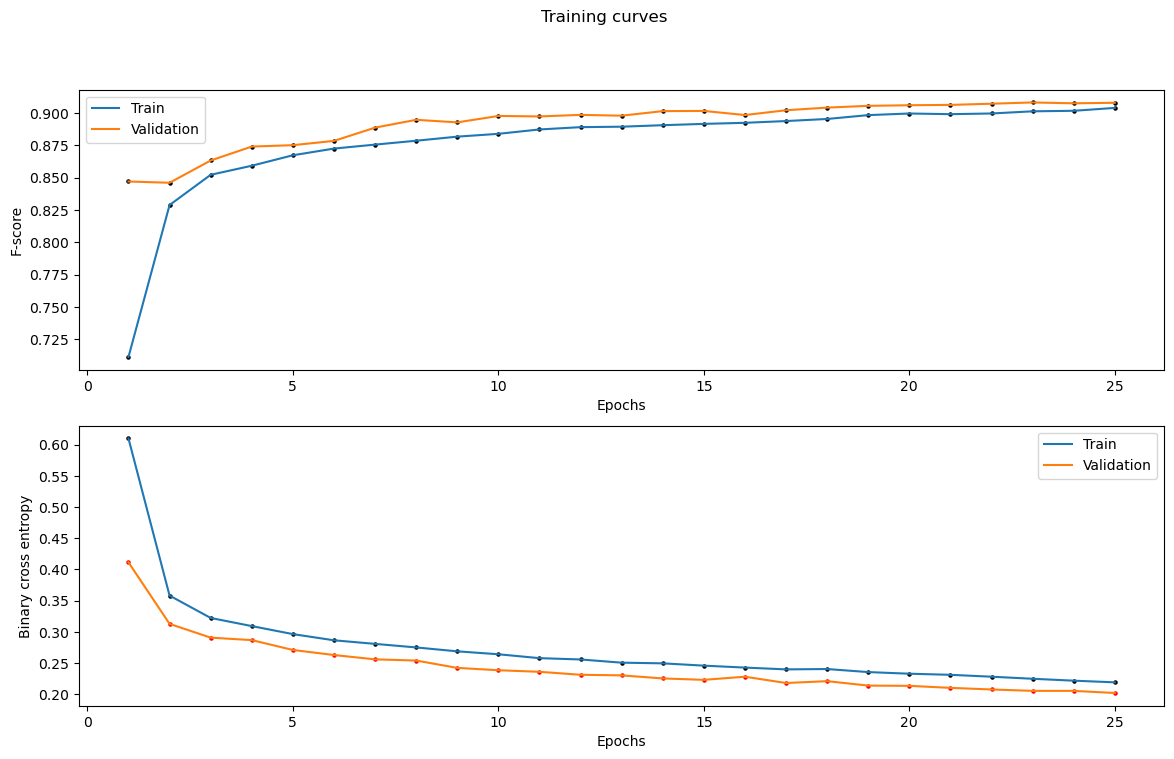

In [11]:
print("Temps d'entrainement : ", time_train, "s")

x = np.arange(1,len(history.history['loss'])+1,1)

plt.figure(figsize=(14,8))
plt.suptitle("Training curves")
plt.subplot(211)
plt.scatter(x,history.history['f_score'], s=5, c='k')
plt.plot(x,history.history['f_score'], label='Train'), plt.legend()
plt.scatter(x,history.history['val_f_score'], s=5, c='k')
plt.plot(x,history.history['val_f_score'], label='Validation'), plt.legend()
plt.ylabel("F-score")
plt.xlabel("Epochs")

plt.subplot(212)
plt.scatter(x,history.history['loss'], s=5, c='k')
plt.plot(x,history.history['loss'], label='Train'), plt.legend()
plt.scatter(x,history.history['val_loss'], s=5, c='r')
plt.plot(x,history.history['val_loss'], label='Validation'), plt.legend()
plt.ylabel("Binary cross entropy")
plt.xlabel("Epochs")

In [12]:
#data set 2 test for testing
"""
X_LS_test = loosen("./data/set2/LS_test.pickle")
X_max_values_test = loosen("./data/set2/Maxs_test.pickle")
Y_test = loosen("./data/set2/Labels_test.pickle")
"""

X_LS_test = np.load('./data/set2/X_LS.npy', allow_pickle=True)
X_max_values_test = np.load('./data/set2/X_max_values.npy', allow_pickle=True)
Y_test = np.load('./data/set2/Y.npy', allow_pickle=True)

#shuffle
c = list(zip(X_LS_test, X_max_values_test,Y_test))
random.shuffle(c)
X_LS_test, X_max_values_test,Y_test = zip(*c)

#Periodogramme
X1_test_tensor = tf.convert_to_tensor(X_LS_test, dtype= 'float32')
X1_test_shape =  [len(X_LS_test),len(X_LS_test[0]), 1]
X1_test = tf.reshape(X1_test_tensor, X1_test_shape )
#Max values
X2_test_tensor = tf.convert_to_tensor(X_max_values_test, dtype= 'float32')
X2_test = tf.reshape(X2_test_tensor, (len(X_max_values_test), len(X_max_values_test[0]),1))
#Label
Y_test_tensor = tf.convert_to_tensor(Y_test)
label_test = tf.reshape(Y_test_tensor, (len(Y_test),1 ))

print("X1_test shape : ", X1_test.shape)
print("X2_test shape : ", X2_test.shape)
print("label_test shape : ", label_test.shape)

X1_test shape :  (10000, 990, 1)
X2_test shape :  (10000, 2, 1)
label_test shape :  (10000, 1)


In [13]:
#Evaluation with samples from dataset2
y_pred_d2 = model.predict( x =[X1_test, X2_test])

313/313 [==============================] - 13s 42ms/step


Best F-score achieve by CNN =  0.869  with threshold =  0.696
Confusion matrix :  [[7001  282]
 [ 411 2306]]


Text(0, 0.5, 'Precision')

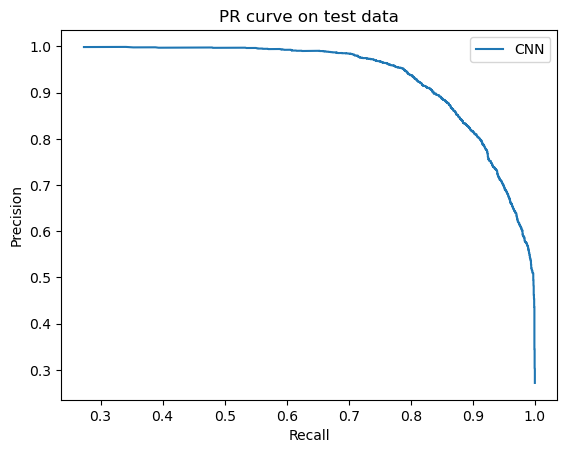

In [14]:
N = 10000
threshold = np.linspace(0.0001,0.9999,N)
P = np.zeros(N)
R = np.zeros(N)
best_score = 0

for i in range(N):
    y_seuil = np.where(y_pred_d2 > threshold[i],1,0)
    P[i] ,R[i],f,m = evaluate(y_seuil,label_test) 
    if (f > best_score) : best_score, best_threshold, best_m = f, threshold[i], m
        
    
print("Best F-score achieve by CNN = ", round(best_score,3), " with threshold = ",round(best_threshold,3) )
print("Confusion matrix : ", best_m)

plt.title("PR curve on test data")
plt.plot(R,P, label='CNN'),  plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")

In [15]:
#Test with data from Nieto papers

labels_test= []
LS_test = []
max_value_test =[]

for filename in np.sort(os.listdir("../Git_article/ExoplANNET/data")):
    
    if filename.endswith(".npy") :
        
        if filename.startswith("pe"): 
             LS_test.append(np.load('../Git_article/ExoplANNET/data/' + filename))
        if filename.startswith("l"): 
             labels_test.append(np.load('../Git_article/ExoplANNET/data/' + filename))
        if filename.startswith("po"): 
             max_value_test.append(np.load('../Git_article/ExoplANNET/data/' + filename))

                
#Concatenate arrays
labels_p = np.concatenate((labels_test[0][:],labels_test[1][:],labels_test[2][:],labels_test[3][:],labels_test[4][:]))
LSs_p = np.concatenate((LS_test[0][:], LS_test[1][:],LS_test[2][:],LS_test[3][:],LS_test[4][:]))
max_values_p = np.concatenate((max_value_test[0][:],max_value_test[1][:],max_value_test[2][:],max_value_test[3][:],max_value_test[4][:]) ) 

#Shuffle
c = list(zip(LSs_p, max_values_p,labels_p))
random.shuffle(c)
LSs_p, max_values_p,labels_p = zip(*c)

for i in range(len(max_values_p)):
    max_values_p[i][0] = freq[round(max_values_p[i][0])]

#Convert to tensor
X1_p = tf.convert_to_tensor(LSs_p, dtype= 'float32')
X_p_shape =  [len(LSs_p),len(X_LS[0]), 1]
X1_p = tf.reshape(X1_p, X_p_shape )

#Max values
X2_p = tf.convert_to_tensor(max_values_p, dtype= 'float32')
X2_p = tf.reshape(X2_p, (len(LSs_p), 2,1))

#Label
Y_p = tf.convert_to_tensor(labels_p)
Y_p = tf.reshape(Y_p, (len(LSs_p),1 ))


print("X1_test shape : ", X1_p.shape)
print("X2_test shape : ", X2_p.shape)
print("Y_test shape : ", Y_p.shape)

X1_test shape :  (20000, 990, 1)
X2_test shape :  (20000, 2, 1)
Y_test shape :  (20000, 1)


In [16]:
#Evaluation
y_pred = model.predict( x =[X1_p, X2_p])

625/625 [==============================] - 27s 43ms/step


Best F-score achieve by CNN =  0.783  with threshold =  0.865
Confusion matrix :  [[14774   813]
 [ 1053  3360]]


Text(0, 0.5, 'Precision')

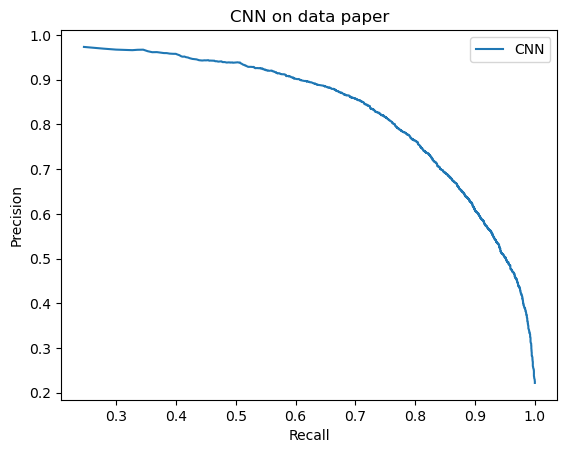

In [17]:
N = 10000
threshold = np.linspace(0.0001,0.9999,N)
P = np.zeros(N)
R = np.zeros(N)
best_score = 0

for i in range(N):
    y_seuil = np.where(y_pred > threshold[i],1,0)
    P[i] ,R[i],f,m = evaluate(y_seuil,Y_p) 
    if (f > best_score) : best_score, best_threshold, best_m = f, threshold[i], m

        
print("Best F-score achieve by CNN = ", round(best_score,3), " with threshold = ",round(best_threshold,3) )
print("Confusion matrix : ", best_m)

plt.title("CNN on data paper")
plt.plot(R,P, label='CNN'),  plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")

# Paper model

In [18]:
model_paper = tf.keras.models.load_model("./../Git_article/ExoplANNET/exoplANNET_trained.h5")

In [19]:
y_pred = model_paper.predict( x =[X1_p, X2_p])

625/625 [==============================] - 26s 41ms/step


Best F-score achieve by CNN =  0.798  with threshold =  0.529
Confusion matrix :  [[14969   618]
 [ 1071  3342]]


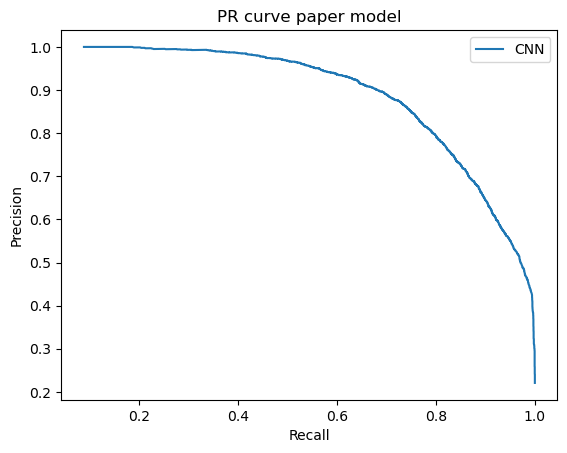

In [20]:
N = 10000
threshold = np.linspace(0.0001,0.9999,N)
P = np.zeros(N)
R = np.zeros(N)
best_score = 0
for i in range(N):
    y_seuil = np.where(y_pred > threshold[i],1,0)
    P[i] ,R[i],f,m = evaluate(y_seuil,Y_p) 
    if (f > best_score) : best_score, best_threshold, best_m = f, threshold[i], m

plt.title("PR curve paper model")
plt.plot(R,P, label='CNN'),  plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")

print("Best F-score achieve by CNN = ", round(best_score,3), " with threshold = ",round(best_threshold,3) )
print("Confusion matrix : ", best_m)

# Comparaison with others methods
### 1) FAP

In [21]:
pdf_mean = loosen("./data/set2/pdf_mean.pickle")

Text(0.5, 0, 'Max amplitude')

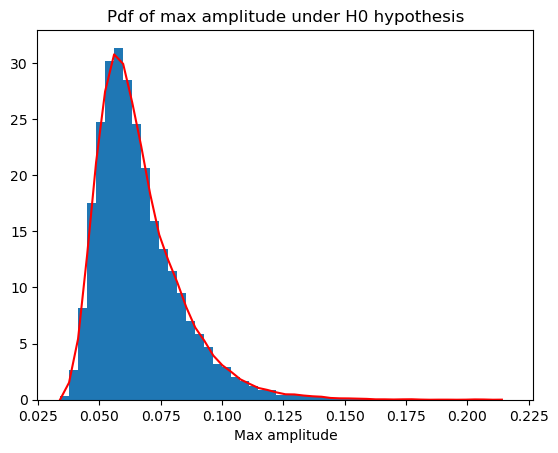

In [22]:
mean_bin = np.zeros(pdf_mean[1].shape[0]-1)
for i in range(pdf_mean[1].shape[0]-1) : mean_bin[i] = (pdf_mean[1][i+1] + pdf_mean[1][i])/2
f_pdf = interpolate.interp1d(mean_bin, pdf_mean[0],bounds_error = False, fill_value = (0,0))

plt.title("Pdf of max amplitude under H0 hypothesis")
plt.bar(pdf_mean[1][:-1], pdf_mean[0], width=np.diff(pdf_mean[1]), align='edge')
plt.plot(pdf_mean[1][:-1], f_pdf(pdf_mean[1][:-1]), c ='r')
plt.xlabel("Max amplitude")

In [23]:
# Function to compute the p-value of a distribution
def compute_p_value( pdf, xi):
    cdf = np.cumsum(pdf[0]*np.diff(pdf[1]))
    mean_bin = np.zeros(pdf[1].shape[0]-1)
    for i in range(pdf[1].shape[0]-1) : mean_bin[i] = (pdf[1][i+1] + pdf[1][i])/2
    f_cdf = interpolate.interp1d(mean_bin, cdf,bounds_error = False, fill_value = (0,1))
    p_value = 1 - f_cdf(xi)
    return p_value

In [24]:
# Predict label with FAP method
def predict_FAP(Maxs, pdf_mean):
    N_test = Maxs.shape[0]
    p_vals = np.zeros(N_test)
    for i in range(N_test):
        p_vals[i] = compute_p_value(pdf_mean,Maxs[i][1])[0]
    return p_vals

In [25]:
y_pred_FAP = predict_FAP(X2_test, pdf_mean)

/tmp/ipykernel_52085/669814629.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  auc1 = integrate.quad(f1, 0, 1)
/tmp/ipykernel_52085/669814629.py:24: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose int


Best F-score achieve by CNN =  0.869  with threshold =  0.707
Confusion matrix : 
 [[7013  270]
 [ 422 2295]]
AUC =  0.951

Best F-score achieve by FAP =  0.845  with threshold =  0.048
Confusion matrix : 
 [[7077  206]
 [ 577 2140]]
AUC =  0.911


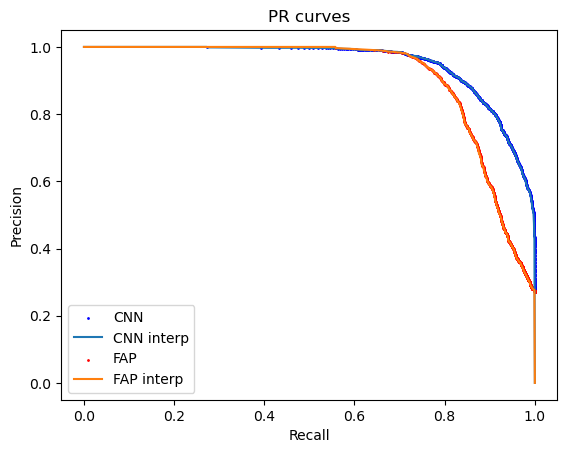

In [26]:
N = 1000
threshold = np.linspace(0.0001,0.9999,N)
P1, R1 = np.zeros(N), np.zeros(N)
False_neg, False_pos = np.zeros(N), np.zeros(N)
P2, R2 = np.zeros(N), np.zeros(N)
best_score_fap = 0
best_score_cnn = 0

for i in range(N):
    y_seuil = np.where(y_pred_d2 > threshold[i],1,0)
    P1[i] ,R1[i],f,m = evaluate(y_seuil,label_test)
    False_pos[i],False_neg[i] = m[0][1], m[1][0]
    if (f > best_score_cnn) : best_score_cnn, best_threshold_cnn, best_m_cnn = f, threshold[i], m
         
    y_seuil = np.where(y_pred_FAP < threshold[i],1,0)
    P2[i] ,R2[i],f,m = evaluate(y_seuil,label_test)
    if (f > best_score_fap) : best_score_fap, best_threshold_fap, best_m_fap = f, threshold[i], m 
        
x_interp = np.linspace(0,1,N)
f1 = interpolate.interp1d(R1, P1,bounds_error = False, fill_value = (1,0))
f2 = interpolate.interp1d(R2, P2,bounds_error = False, fill_value = (1,0))

auc1 = integrate.quad(f1, 0, 1)
auc2 = integrate.quad(f2, 0, 1)

plt.figure()
plt.title("PR curves")
plt.scatter(R1,P1, label ='CNN',s = 1, c ='b'), plt.legend()
plt.plot(x_interp,f1(x_interp),label='CNN interp'),plt.legend()
plt.scatter(R2,P2, label='FAP',s = 1, c ='r'),  plt.legend()
plt.plot(x_interp,f2(x_interp),label='FAP interp'),plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")

print("\nBest F-score achieve by CNN = ", round(best_score_cnn,3), " with threshold = ",round(best_threshold_cnn,3) )
print("Confusion matrix : \n", best_m_cnn)
print("AUC = ", round(auc1[0],3))
print("\nBest F-score achieve by FAP = ", round(best_score_fap,3), " with threshold = ",round(best_threshold_fap,3) )
print("Confusion matrix : \n", best_m_fap)
print("AUC = ", round(auc2[0],3))

In [27]:
y_cnn_H0 = y_pred_d2[np.where(label_test == 0)[0]]
y_cnn_H1 = y_pred_d2[np.where(label_test == 1)[0]]
dist_cnn_H0 = np.histogram(y_cnn_H0, bins = 50, density = True)
dist_cnn_H1 = np.histogram(y_cnn_H1, bins = 50, density = True)

y_fap_H0 = 1-y_pred_FAP[np.where(label_test == 0)[0]]
y_fap_H1 = 1-y_pred_FAP[np.where(label_test == 1)[0]]
dist_fap_H0 = np.histogram(y_fap_H0, bins = 50, density = True)
dist_fap_H1 = np.histogram(y_fap_H1, bins = 50, density = True)

Text(0, 0.5, 'Density')

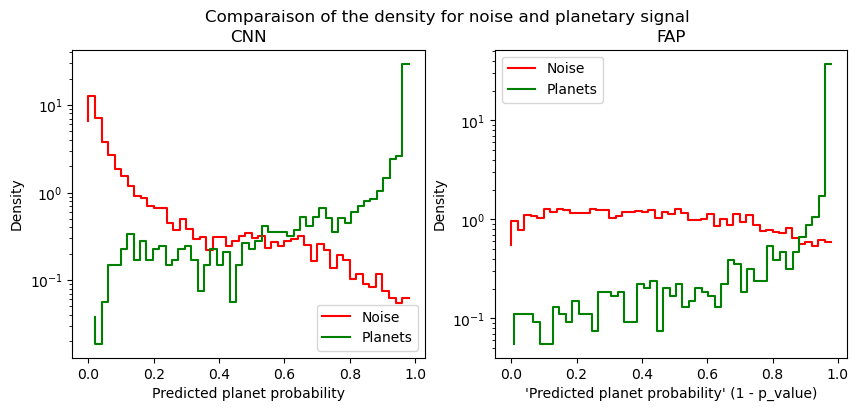

In [28]:
plt.figure(figsize = (10,4))
plt.suptitle("Comparaison of the density for noise and planetary signal")
plt.subplot(121)
plt.title("CNN")
plt.step(dist_cnn_H0[1][:-1], dist_cnn_H0[0], color="red", label="Noise"), plt.legend()
plt.step(dist_cnn_H1[1][:-1], dist_cnn_H1[0],color= 'green', label ='Planets'),plt.legend()
plt.yscale('log')
plt.xlabel("Predicted planet probability")
plt.ylabel("Density")

plt.subplot(122)
plt.title("FAP")
plt.step(dist_fap_H0[1][:-1], dist_fap_H0[0], color="red", label="Noise"), plt.legend()
plt.step(dist_fap_H1[1][:-1], dist_fap_H1[0],color= 'green', label ='Planets'), plt.legend()
plt.yscale('log')
plt.xlabel("'Predicted planet probability' (1 - p_value)")
plt.ylabel("Density")

### Define threshold for the CNN

In [29]:
#Reference with FAP method with p-value of 0.05
y_seuil = np.where(y_pred_FAP < 0.05 ,1,0)
p,r,f,m = evaluate(y_seuil,label_test)
false_pos_fap = m[0][1]
false_neg_fap = m[1][0]

Range of possible threshold to use in CNN for better performance : [ 0.73 , 0.8 ]


<Figure size 640x480 with 0 Axes>

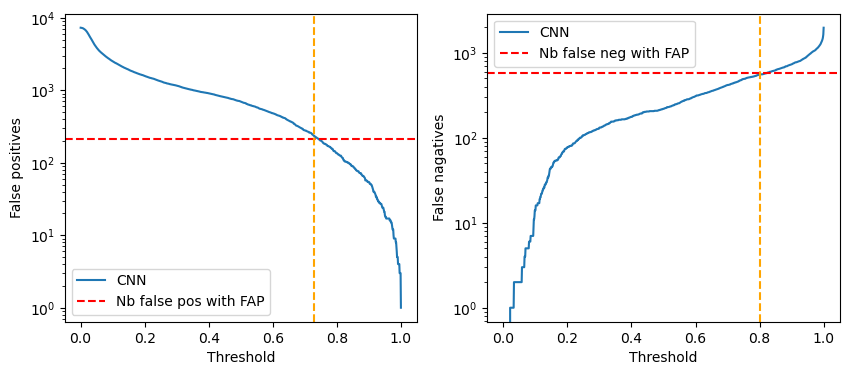

In [30]:
"""
f = np.polyfit(threshold1, False_pos, 20)
p = np.poly1d(f)
y = p(threshold)
"""

plt.figure()
plt.figure(figsize = (10,4))
plt.subplot(121)
plt.plot(threshold, False_pos, label='CNN'), plt.legend()
x_pos = 0.73
plt.axhline(y=false_pos_fap, color='r', linestyle='--',label='Nb false pos with FAP'),plt.legend()
plt.axvline(x=x_pos, color='orange', linestyle='--')
plt.yscale('log')
plt.xlabel("Threshold")
plt.ylabel("False positives")

plt.subplot(122)
plt.plot(threshold, False_neg, label='CNN'),plt.legend()
plt.axhline(y=false_neg_fap, color='r', linestyle='--', label='Nb false neg with FAP'),plt.legend()
x_neg = 0.80
plt.axvline(x=x_neg, color='orange', linestyle='--')
plt.yscale('log')
plt.xlabel("Threshold")
plt.ylabel("False nagatives")

print("Range of possible threshold to use in CNN for better performance : [",x_pos,",",x_neg,"]")

In [31]:
#Comparaison beetwen CNN with founded threshold and FAP with p_value 0.05
opt_threshold = x_neg
y_seuil_cnn = np.where(y_pred_d2 > opt_threshold,1,0)
p1 ,r1,f1,m1 = evaluate(y_seuil_cnn,label_test)

y_seuil_fap = np.where(y_pred_FAP < 0.05 ,1,0)
p2,r2,f2,m2 = evaluate(y_seuil_fap,label_test)

print("CNN Method")
print("Confusion matrix :\n", m1)
print("Precision = ", round(p1,3), ",Recall = ",round(r1,3))
print("\nFAP Method")
print("Confusion matrix :\n", m2)
print("Precision = ", round(p2,3), ",Recall = ",round(r2,3))

CNN Method
Confusion matrix :
 [[7147  136]
 [ 554 2163]]
Precision =  0.941 ,Recall =  0.796

FAP Method
Confusion matrix :
 [[7069  214]
 [ 572 2145]]
Precision =  0.909 ,Recall =  0.789


In [32]:
N = 10
precision_cnn, precision_fap = np.zeros(N-1), np.zeros(N-1)
recall_cnn, recall_fap = np.zeros(N-1), np.zeros(N-1)

for i in range(1,N):
    ind = np.where( np.logical_and( X2_test[:,0,0] > 0.01*i, X2_test[:,0,0] < 0.01*(i+1)))[0]
    print("Between ", 0.01*i, " and ", 0.01*(i+1), " shape = ", ind.shape)
    y_pred_cnn = model.predict( x = [ tf.gather(X1_test, ind) , tf.gather(X2_test, ind ) ] )
    y_pred_fap = predict_FAP( tf.gather(X2_test, ind ), pdf_mean)
    
    y_seuil_cnn = np.where(y_pred_cnn > opt_threshold,1,0)
    y_seuil_fap = np.where(y_pred_fap < 0.05 ,1,0)
    
    precision_cnn[i-1], recall_cnn[i-1], f,m = evaluate(y_seuil_cnn,tf.gather(label_test,indices=ind))
    precision_fap[i-1], recall_fap[i-1], f,m = evaluate(y_seuil_fap,tf.gather(label_test,indices=ind))

Between  0.01  and  0.02  shape =  (1579,)
50/50 [==============================] - 2s 40ms/step
Between  0.02  and  0.03  shape =  (770,)
25/25 [==============================] - 1s 50ms/step
Between  0.03  and  0.04  shape =  (590,)
19/19 [==============================] - 1s 49ms/step
Between  0.04  and  0.05  shape =  (439,)
14/14 [==============================] - 1s 46ms/step
Between  0.05  and  0.06  shape =  (423,)
14/14 [==============================] - 1s 41ms/step
Between  0.06  and  0.07  shape =  (342,)
11/11 [==============================] - 0s 39ms/step
Between  0.07  and  0.08  shape =  (316,)
10/10 [==============================] - 0s 40ms/step
Between  0.08  and  0.09  shape =  (295,)
10/10 [==============================] - 0s 41ms/step
Between  0.09  and  0.1  shape =  (276,)
9/9 [==============================] - 0s 43ms/step


Text(0, 0.5, 'Recall')

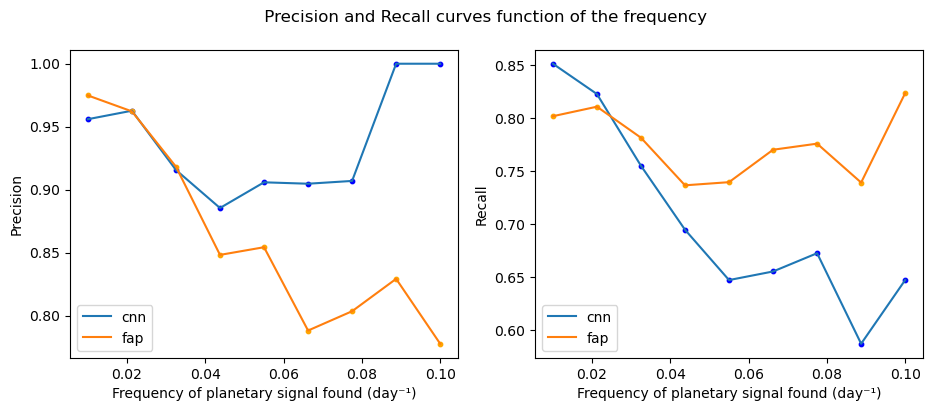

In [33]:
x = np.linspace(0.01, 0.1, N-1)
plt.figure(figsize=(11,4))
plt.suptitle(" Precision and Recall curves function of the frequency")
plt.subplot(121)
plt.scatter(x,precision_cnn, c='b', s=10),plt.plot(x,precision_cnn, label ='cnn'),plt.legend()
plt.scatter(x,precision_fap, c='orange', s=10),plt.plot(x,precision_fap,label ='fap'),plt.legend()
plt.xlabel('Frequency of planetary signal found (day⁻¹)')
plt.ylabel('Precision')
plt.subplot(122)
plt.scatter(x,recall_cnn, c='b', s=10), plt.plot(x,recall_cnn, label ='cnn'),plt.legend()
plt.scatter(x,recall_fap, c='orange', s=10), plt.plot(x,recall_fap,label ='fap'),plt.legend()
plt.xlabel('Frequency of planetary signal found (day⁻¹)')
plt.ylabel('Recall')

 Prot = [5 ; 90] ; P_pl = [10 ; 100] 

Text(0, 0.5, 'Recall')

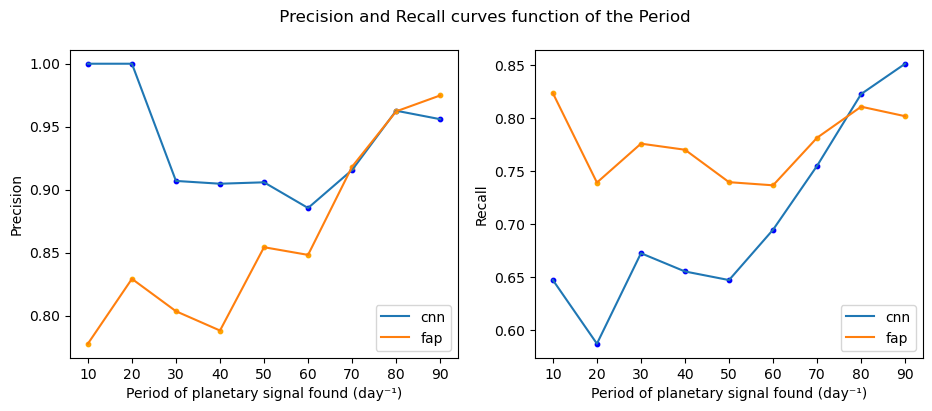

In [34]:
x = np.linspace(10, 90, N-1)
plt.figure(figsize=(11,4))
plt.suptitle(" Precision and Recall curves function of the Period")
plt.subplot(121)
plt.scatter(x,np.flip(precision_cnn), c='b', s=10),plt.plot(x,np.flip(precision_cnn), label ='cnn'),plt.legend()
plt.scatter(x,np.flip(precision_fap), c='orange', s=10),plt.plot(x,np.flip(precision_fap),label ='fap'),plt.legend()
plt.xlabel('Period of planetary signal found (day⁻¹)')
plt.ylabel('Precision')
plt.subplot(122)
plt.scatter(x,np.flip(recall_cnn), c='b', s=10), plt.plot(x,np.flip(recall_cnn), label ='cnn'),plt.legend()
plt.scatter(x,np.flip(recall_fap), c='orange', s=10), plt.plot(x,np.flip(recall_fap),label ='fap'),plt.legend()
plt.xlabel('Period of planetary signal found (day⁻¹)')
plt.ylabel('Recall')

# Dataset 4, fixed parameters for GP

In [35]:
X_LS = np.load('./data/set4/X_LS.npy',allow_pickle = True)
X_max_values = np.load('./data/set4/X_max_values.npy',allow_pickle = True)
Y = np.load('./data/set4/Y.npy',allow_pickle = True)
freq = np.load('./data/set4/freq.npy',allow_pickle = True)

In [36]:
#Data pre-processing 
#shuffle
c = list(zip(X_LS, X_max_values,Y))
random.shuffle(c)
X_LS, X_max_values,Y = zip(*c)
#Periodogramme
X_shape =  [N_data,len(X_LS[0]), 1]
X1_tensor = tf.convert_to_tensor(X_LS, dtype = 'float32')
X1 = tf.reshape(X1_tensor, X_shape )
#Max values
X2_tensor = tf.convert_to_tensor(X_max_values, dtype = 'float32')
X2 = tf.reshape(X2_tensor, (N_data, 2,1))
#Label
Y_tensor = tf.convert_to_tensor(Y,dtype='float32')
Y = tf.reshape(Y_tensor, (N_data,1 ))
#Split train/validation
pourcentage = 0.8
split = round(pourcentage * N_data)
X_train12, X_val12 = X1[0:split, :, :], X1[split:, :, :]
X_train22,X_val22 = X2[0:split, :, :], X2[split:, :, :]
Y_train2, Y_val2 = Y[0:split], Y[split:,:]
print("Periodogramme train size : ", X_train12.shape)
print("Periodogramme validation size : ", X_val12.shape,"\n")
print("Max_values train size : ", X_train22.shape)
print("Max_values validation size : ", X_val22.shape,"\n")
print("Label train size : ", Y_train2.shape)
print("Label validation size : ", Y_val2.shape)

Periodogramme train size :  (10960, 990, 1)
Periodogramme validation size :  (2740, 990, 1) 

Max_values train size :  (10960, 2, 1)
Max_values validation size :  (2740, 2, 1) 

Label train size :  (10960, 1)
Label validation size :  (2740, 1)


In [37]:
#Model with functional API Keras

#periodogramme as input to a CNN
inputs12 = tf.keras.Input(shape=(990,1))
x1 = layers.Conv1D(filters = 32, kernel_size = 2, strides = 1, padding = 'same',
                   activation='relu', use_bias = True,input_shape= (990,))(inputs12)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(32,6,padding = 'same', activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(32,8,padding = 'same', activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
outputs12 = layers.Flatten()(x1)

#max_values as input to a dense layers 
inputs22 = tf.keras.Input(shape=(2,1))
x2 = layers.Dense(2, activation = 'relu')(inputs22)
outputs22 =  layers.Flatten()(x2)

#output of the two network concatenate for input as a dense final network
x = layers.concatenate([outputs12, outputs22])

x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
outputs2 = layers.Dense(1,activation = 'sigmoid')(x)

model2 = tf.keras.Model(inputs=[inputs12,inputs22], outputs=outputs2, name ="ExoplANNET2")

In [38]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_f_score', patience = 2, mode = "max",
                                                  restore_best_weights = True, start_from_epoch = 5)

model2.compile( loss = tf.keras.losses.BinaryCrossentropy(from_logits= False),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-4),
              metrics =[tf.keras.metrics.BinaryAccuracy(),precision_m, recall_m, f_score])

y_before_train = model2.evaluate( x = [X_train12, X_train22], y = Y_train2, batch_size = 128)

86/86 [==============================] - 4s 42ms/step - loss: 0.6935 - binary_accuracy: 0.2713 - precision_m: 0.2854 - recall_m: 0.2967 - f_score: 0.2895


In [39]:
#Train the network
start = time.time()
history = model2.fit(x = [X_train12, X_train22], y = Y_train2, batch_size = 128, epochs = 50, verbose = 1,
                    callbacks=[early_stopping], validation_data = ([X_val12,X_val22], Y_val2))                                                      
time_train = time.time() - start

Epoch 1/50
86/86 [==============================] - 12s 127ms/step - loss: 0.6419 - binary_accuracy: 0.7412 - precision_m: 0.9418 - recall_m: 0.5267 - f_score: 0.6641 - val_loss: 0.4701 - val_binary_accuracy: 0.8314 - val_precision_m: 0.9895 - val_recall_m: 0.6644 - val_f_score: 0.7927
Epoch 2/50
86/86 [==============================] - 11s 128ms/step - loss: 0.3500 - binary_accuracy: 0.8626 - precision_m: 0.9371 - recall_m: 0.7848 - f_score: 0.8504 - val_loss: 0.2703 - val_binary_accuracy: 0.8916 - val_precision_m: 0.9244 - val_recall_m: 0.8484 - val_f_score: 0.8839
Epoch 3/50
86/86 [==============================] - 11s 133ms/step - loss: 0.2593 - binary_accuracy: 0.8929 - precision_m: 0.9356 - recall_m: 0.8466 - f_score: 0.8875 - val_loss: 0.2394 - val_binary_accuracy: 0.9007 - val_precision_m: 0.9453 - val_recall_m: 0.8470 - val_f_score: 0.8922
Epoch 4/50
86/86 [==============================] - 12s 145ms/step - loss: 0.2262 - binary_accuracy: 0.9086 - precision_m: 0.9475 - recall_

Temps d'entrainement :  168.5348677635193 s


Text(0.5, 0, 'Epochs')

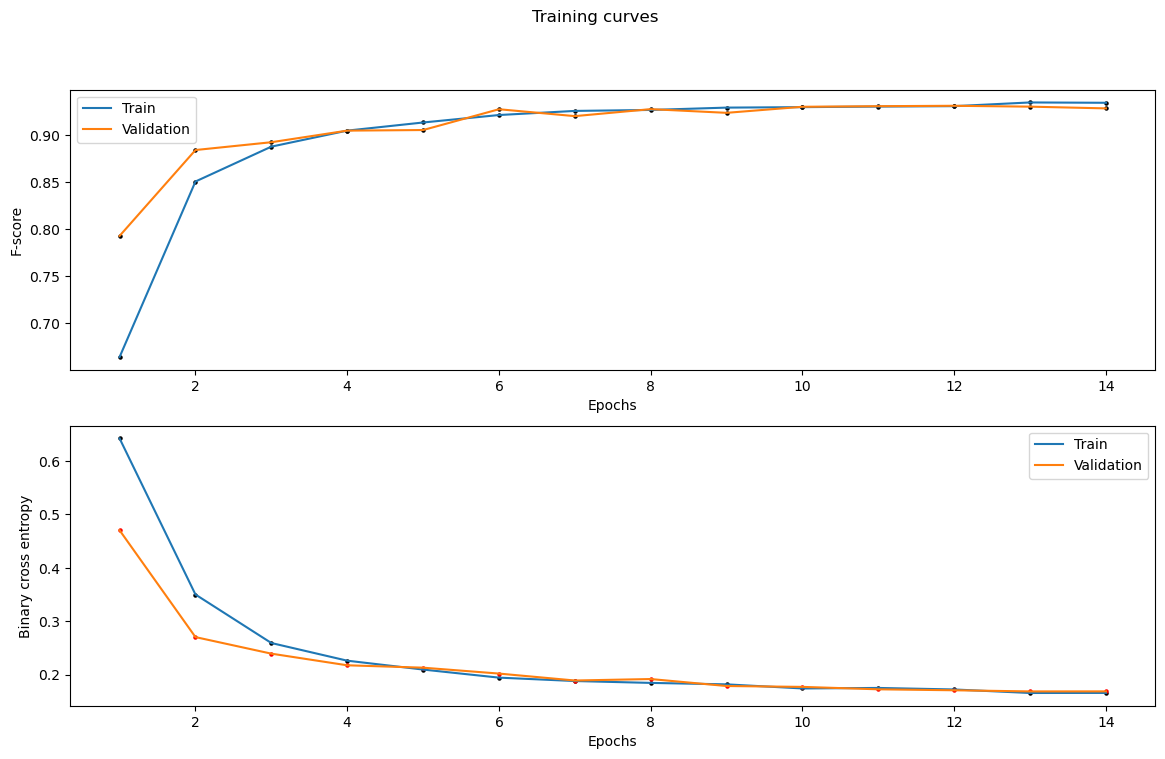

In [40]:
print("Temps d'entrainement : ", time_train, "s")
x = np.arange(1,len(history.history['loss'])+1,1)

plt.figure(figsize=(14,8))
plt.suptitle("Training curves")
plt.subplot(211)
plt.scatter(x,history.history['f_score'], s=5, c='k')
plt.plot(x,history.history['f_score'], label='Train'), plt.legend()
plt.scatter(x,history.history['val_f_score'], s=5, c='k')
plt.plot(x,history.history['val_f_score'], label='Validation'), plt.legend()
plt.ylabel("F-score")
plt.xlabel("Epochs")

plt.subplot(212)
plt.scatter(x,history.history['loss'], s=5, c='k')
plt.plot(x,history.history['loss'], label='Train'), plt.legend()
plt.scatter(x,history.history['val_loss'], s=5, c='r')
plt.plot(x,history.history['val_loss'], label='Validation'), plt.legend()
plt.ylabel("Binary cross entropy")
plt.xlabel("Epochs")

In [41]:
# Load dataset for testing
X_LS_test = np.load('./data/set5/X_LS.npy', allow_pickle=True)
X_max_values_test = np.load('./data/set5/X_max_values.npy', allow_pickle=True)
Y_test = np.load('./data/set5/Y.npy', allow_pickle=True)

#shuffle
c = list(zip(X_LS_test, X_max_values_test,Y_test))
random.shuffle(c)
X_LS_test, X_max_values_test,Y_test = zip(*c)

#Periodogramme
X1_test_tensor = tf.convert_to_tensor(X_LS_test, dtype= 'float32')
X1_test_shape =  [len(X_LS_test),len(X_LS_test[0]), 1]
X12_test = tf.reshape(X1_test_tensor, X1_test_shape )
#Max values
X2_test_tensor = tf.convert_to_tensor(X_max_values_test, dtype= 'float32')
X22_test = tf.reshape(X2_test_tensor, (len(X_max_values_test), len(X_max_values_test[0]),1))
#Label
Y_test_tensor = tf.convert_to_tensor(Y_test)
label_test2 = tf.reshape(Y_test_tensor, (len(Y_test),1 ))

print("X1_test shape : ", X12_test.shape)
print("X2_test shape : ", X22_test.shape)
print("label_test shape : ", label_test2.shape)

X1_test shape :  (10000, 990, 1)
X2_test shape :  (10000, 2, 1)
label_test shape :  (10000, 1)


In [42]:
#Evaluation with samples from dataset2
y_pred_d22 = model2.predict( x =[X12_test, X22_test])

313/313 [==============================] - 14s 44ms/step


/tmp/ipykernel_52085/2756371378.py:30: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  auc1 = integrate.quad(f1, 0, 1)
/tmp/ipykernel_52085/2756371378.py:31: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose i


Best F-score achieve by CNN1 =  0.869  with threshold =  0.707
Confusion matrix : 
 [[7013  270]
 [ 422 2295]]
AUC =  0.951

Best F-score achieve by FAP =  0.845  with threshold =  0.048
Confusion matrix : 
 [[7077  206]
 [ 577 2140]]
AUC =  0.911

Best F-score achieve by CNN2 =  0.915  with threshold =  0.535
Confusion matrix : 
 [[6740  279]
 [ 233 2748]]
AUC =  0.976


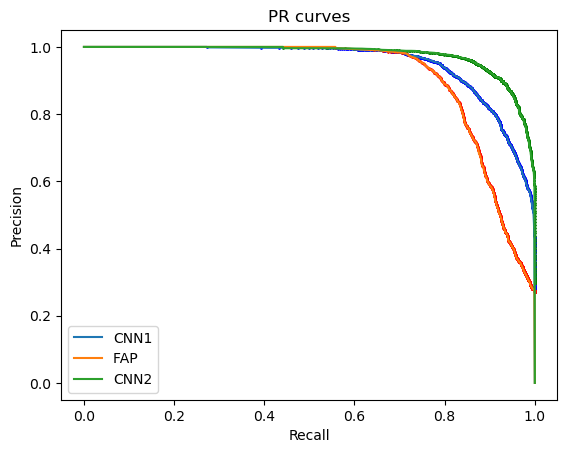

In [45]:
N = 1000
threshold = np.linspace(0.0001,0.9999,N)

P1, R1 = np.zeros(N), np.zeros(N)
P2, R2 = np.zeros(N), np.zeros(N)
P3, R3 = np.zeros(N), np.zeros(N)

best_score_fap = 0
best_score_cnn1 = 0
best_score_cnn2 = 0

for i in range(N):
    y_seuil = np.where(y_pred_d2 > threshold[i],1,0)
    P1[i] ,R1[i],f,m = evaluate(y_seuil,label_test)
    if (f > best_score_cnn1) : best_score_cnn1, best_threshold_cnn1, best_m_cnn1 = f, threshold[i], m
         
    y_seuil = np.where(y_pred_FAP < threshold[i],1,0)
    P2[i] ,R2[i],f,m = evaluate(y_seuil,label_test)
    if (f > best_score_fap) : best_score_fap, best_threshold_fap, best_m_fap = f, threshold[i], m 
        
    y_seuil = np.where(y_pred_d22 > threshold[i],1,0)
    P3[i] ,R3[i],f,m = evaluate(y_seuil,label_test2)
    if (f > best_score_cnn2) : best_score_cnn2, best_threshold_cnn2, best_m_cnn2 = f, threshold[i], m 
        
x_interp = np.linspace(0,1,N)
f1 = interpolate.interp1d(R1, P1,bounds_error = False, fill_value = (1,0))
f2 = interpolate.interp1d(R2, P2,bounds_error = False, fill_value = (1,0))
f3 = interpolate.interp1d(R3, P3,bounds_error = False, fill_value = (1,0))

auc1 = integrate.quad(f1, 0, 1)
auc2 = integrate.quad(f2, 0, 1)
auc3 = integrate.quad(f3, 0, 1)

plt.figure()
plt.title("PR curves")
plt.scatter(R1,P1, s = 1, c ='b')
plt.plot(x_interp,f1(x_interp),label='CNN1'),plt.legend()
plt.scatter(R2,P2,s = 1, c ='r'), 
plt.plot(x_interp,f2(x_interp),label='FAP '),plt.legend()
plt.scatter(R3,P3,s = 1, c ='g')
plt.plot(x_interp,f3(x_interp),label='CNN2'),plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")

print("\nBest F-score achieve by CNN1 = ", round(best_score_cnn1,3), " with threshold = ",round(best_threshold_cnn1,3) )
print("Confusion matrix : \n", best_m_cnn1)
print("AUC = ", round(auc1[0],3))
print("\nBest F-score achieve by FAP = ", round(best_score_fap,3), " with threshold = ",round(best_threshold_fap,3) )
print("Confusion matrix : \n", best_m_fap)
print("AUC = ", round(auc2[0],3))
print("\nBest F-score achieve by CNN2 = ", round(best_score_cnn2,3), " with threshold = ",round(best_threshold_cnn2,3) )
print("Confusion matrix : \n", best_m_cnn2)
print("AUC = ", round(auc3[0],3))